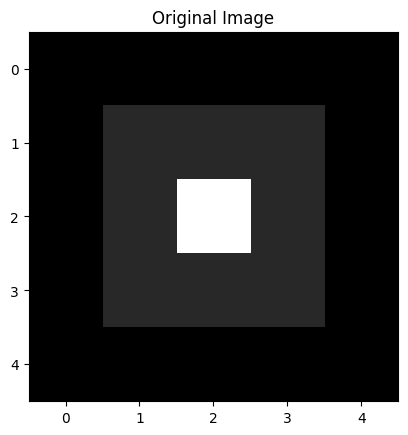

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Sample image
img = np.array([
    [10, 10, 10, 10, 10],
    [10, 50, 50, 50, 10],
    [10, 50, 255, 50, 10],
    [10, 50, 50, 50, 10],
    [10, 10, 10, 10, 10]
], dtype=np.uint8)

plt.imshow(img, cmap='gray')
plt.title("Original Image")
plt.show()

In [ ]:
## Canny Edge Detection

In [ ]:
gradient_direction

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 90.        ,  90.        ,  78.69006753, ...,  20.55604522,
         45.        ,  90.        ],
       [ 90.        ,  68.19859051,  78.69006753, ...,  30.96375653,
         71.56505118,  90.        ],
       ...,
       [ 90.        ,  47.1210964 ,   0.        , ...,  21.50143432,
          4.08561678,  90.        ],
       [ 90.        ,  67.61986495, 153.43494882, ..., 129.09385889,
        124.87532834,  90.        ],
       [  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ]])

In [ ]:
gradient_magnitude

array([[ 0.        ,  0.        ,  0.        , ..., 16.        ,
         6.        ,  0.        ],
       [ 4.        ,  4.        ,  5.09901951, ..., 17.08800749,
         7.07106781,  4.        ],
       [ 6.        , 10.77032961, 20.39607805, ..., 17.49285568,
         6.32455532,  4.        ],
       ...,
       [40.        , 38.20994635, 20.        , ..., 35.4682957 ,
        28.0713377 ,  2.        ],
       [24.        , 18.38477631,  4.47213595, ..., 41.23105626,
        40.22437072, 34.        ],
       [ 0.        ,  0.        , 12.        , ..., 26.        ,
        22.        ,  0.        ]])

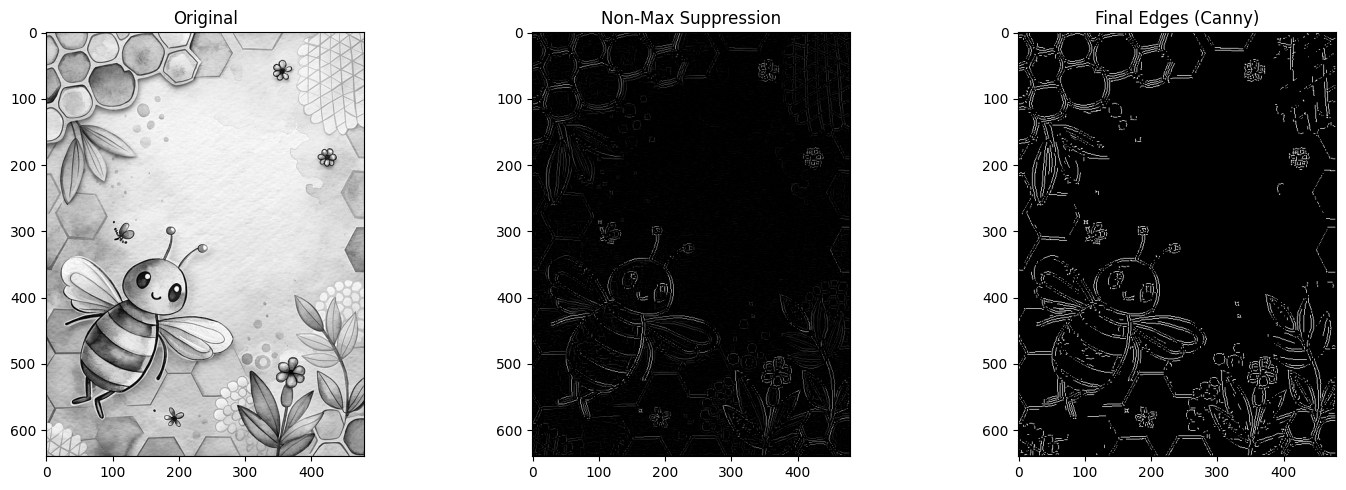

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Step 0: Load Image (grayscale)
img = cv2.imread('bee-8790316_640.jpg', cv2.IMREAD_GRAYSCALE)

# Step 1: Noise Reduction using Gaussian Blur
blurred = cv2.GaussianBlur(img, (5, 5), 1.4)

# Step 2: Compute Gradients using Sobel
sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1)

gradient_magnitude = np.hypot(sobelx, sobely)
gradient_direction = np.arctan2(sobely, sobelx) * 180 / np.pi
gradient_direction %= 180  # Convert to [0, 180)

# Step 3: Non-Maximum Suppression
def non_max_suppression(grad_mag, grad_dir):
    H, W = grad_mag.shape
    output = np.zeros((H, W), dtype=np.float32)
    for i in range(1, H-1):
        for j in range(1, W-1):
            angle = grad_dir[i, j]
            q = 255
            r = 255

            if (0 <= angle < 22.5) or (157.5 <= angle < 180):
                q = grad_mag[i, j+1]
                r = grad_mag[i, j-1]
            elif (22.5 <= angle < 67.5):
                q = grad_mag[i-1, j+1]
                r = grad_mag[i+1, j-1]
            elif (67.5 <= angle < 112.5):
                q = grad_mag[i-1, j]
                r = grad_mag[i+1, j]
            elif (112.5 <= angle < 157.5):
                q = grad_mag[i-1, j-1]
                r = grad_mag[i+1, j+1]

            if (grad_mag[i, j] >= q) and (grad_mag[i, j] >= r):
                output[i, j] = grad_mag[i, j]
            else:
                output[i, j] = 0

    return output

nms = non_max_suppression(gradient_magnitude, gradient_direction)

# Step 4: Double Thresholding
def double_threshold(img, low, high):
    strong = 255
    weak = 75

    strong_i, strong_j = np.where(img >= high)
    weak_i, weak_j = np.where((img <= high) & (img >= low))

    result = np.zeros_like(img)
    result[strong_i, strong_j] = strong
    result[weak_i, weak_j] = weak

    return result, weak, strong

dt_result, weak, strong = double_threshold(nms, low=50, high=100)

# Step 5: Edge Tracking by Hysteresis
def hysteresis(img, weak=75, strong=255):
    H, W = img.shape
    for i in range(1, H-1):
        for j in range(1, W-1):
            if img[i, j] == weak:
                if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                    or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                    or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                    img[i, j] = strong
                else:
                    img[i, j] = 0
    return img

final_edges = hysteresis(dt_result)

# Show Results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img, cmap='gray')

plt.subplot(1, 3, 2)
plt.title("Non-Max Suppression")
plt.imshow(nms, cmap='gray')

plt.subplot(1, 3, 3)
plt.title("Final Edges (Canny)")
plt.imshow(final_edges, cmap='gray')

plt.tight_layout()
plt.show()